### Import libraries

In [1]:
%%capture
#!pip install scanpy
#!pip install KDEpy
#!pip install leidenalg

In [2]:
%%capture
# Remember to restart the kernel once installed
#!pip install -e ../../../tools/nomad/

In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import scipy.sparse as sps
from scipy.stats import spearmanr, kendalltau, pearsonr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools.util as ut
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import fi_nomad as nmd
from fi_nomad.types import kernelInputTypes
from fi_nomad.types import KernelStrategy
from fi_nomad.types import InitializationStrategy

import warnings

warnings.filterwarnings("ignore")

import importlib
import logging

In [2]:
# logging has to manually turned on to see nomad output
logging.basicConfig(level=logging.INFO)

### Read data

In [3]:
data_path = "../data/S2"
figure_path = f"{data_path}/figures/normalized_counts"
layer = "normalized_counts"

In [4]:
data = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed_and_pca.h5ad")
data

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'leiden_opt_PCA'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'is_scd_outlier', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_mean', 'nb_umi', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'mean', 'std'
    uns: 'BacSC_params_PCA', 'PCA', 'leiden', 'leiden_opt_PCA_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized_counts', 'vst_counts'
    obsp: 'PCA_connectivities', 'PCA_distances'

### Countsplit

In [5]:
data_train, data_test = cs.countsplit_adata(
    data,
    data_dist="NB",
    beta_key="nb_overdisp_cutoff",
    layer="counts",
    min_genes=1,
    max_counts=1e9,
    seed=1234,
)

Normalize splits

In [6]:
normalization_target_sum = data.obs["total_counts"].median()

In [7]:
data_train.layers["normalized_counts"] = data_train.layers["counts"].copy()
sc.pp.normalize_total(
    data_train, target_sum=normalization_target_sum, layer="normalized_counts"
)

data_test.layers["normalized_counts"] = data_test.layers["counts"].copy()
sc.pp.normalize_total(
    data_test, target_sum=normalization_target_sum, layer="normalized_counts"
)

### Search latent dimension and momentum parameter

In [8]:
ks_2_check = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
betas_2_check = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas_2_check

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In case you don't want to rerun:

In [18]:
k_opt = 1
beta_opt = 0.6

In [9]:
select_cs_results = cs.select_3b_params_countsplit(
    data_train,
    data_test,
    potential_ks=ks_2_check,
    potential_betas=betas_2_check,
    layer=layer,
    maxiters=200,
)

################## LATENT DIM 10


INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 5.3654000112146605e-05 loop took 35.933122044999436 overall (0.1796656102249972/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.397599994059419e-05 loop took 35.7130304100001 overall (0.1785651520500005/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 8.961999992607161e-05 loop took 35.67828477900002 overall (0.17839142389500012/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.948299970739754e-05 loop took 35.99578245199973 overall (0.17997891225999865/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0189000426616985e-05 loop took 34.913873640999554 overall (0.17456936820499777/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7945000510953832e-05 loop took 34.96020916699945 overall (0.17480104583499723/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.627699970820686e-05 loop took 34.60358339800041 overall (0.17301791699000205/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 5.524600055650808e-05 loop took 34.71791391199986 overall (0.1735895695599993/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 10, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.89270001303521e-05 loop took 35.17074965200027 overall (0.17585374826000133/ea)


################## LATENT DIM 9


INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.6811999962083064e-05 loop took 34.35979767900062 overall (0.1717989883950031/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.737299994099885e-05 loop took 34.2599863129999 overall (0.1712999315649995/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9083000299578998e-05 loop took 34.323506867000106 overall (0.17161753433500052/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8657000257226173e-05 loop took 34.14331796599981 overall (0.17071658982999907/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.941300019505434e-05 loop took 34.20900051999979 overall (0.17104500259999894/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9530999199778307e-05 loop took 34.28267895800036 overall (0.1714133947900018/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.514200034260284e-05 loop took 34.289478120999775 overall (0.17144739060499886/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8295999982219655e-05 loop took 34.076016492000235 overall (0.17038008246000116/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 9, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7814000532089267e-05 loop took 36.09524729799978 overall (0.1804762364899989/ea)


################## LATENT DIM 8


INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.8561999645025935e-05 loop took 33.53323851000005 overall (0.16766619255000023/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.690100038511446e-05 loop took 33.71371051699953 overall (0.16856855258499764/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8569999813043978e-05 loop took 32.00810455200008 overall (0.1600405227600004/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.546600080677308e-05 loop took 32.624914523999905 overall (0.16312457261999952/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.63639994955156e-05 loop took 35.13696958000037 overall (0.17568484790000183/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.66739998551202e-05 loop took 36.139670524000394 overall (0.18069835262000197/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.539600038493518e-05 loop took 32.321357003999765 overall (0.1616067850199988/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.940499962278409e-05 loop took 36.102860611000324 overall (0.18051430305500163/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 8, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6346000595367514e-05 loop took 42.534279550000065 overall (0.21267139775000032/ea)


################## LATENT DIM 7


INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.5957000363850966e-05 loop took 34.10175531999994 overall (0.1705087765999997/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.842099951929413e-05 loop took 32.42816644400045 overall (0.16214083222000228/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5860000278044026e-05 loop took 31.88146066399986 overall (0.1594073033199993/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5540000024193432e-05 loop took 33.1246833590003 overall (0.1656234167950015/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.819900055328617e-05 loop took 34.63493795899922 overall (0.1731746897949961/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6805999368662015e-05 loop took 32.88923906400032 overall (0.1644461953200016/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.386000025784597e-05 loop took 31.628616268999394 overall (0.15814308134499697/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.658500034158351e-05 loop took 34.39980370400008 overall (0.17199901852000038/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 7, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.7414000214776024e-05 loop took 36.623358972999995 overall (0.183116794865/ea)


################## LATENT DIM 6


INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0266000067058485e-05 loop took 32.97131615800026 overall (0.16485658079000132/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.561300036380999e-05 loop took 32.77233330400031 overall (0.16386166652000156/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.405900042707799e-05 loop took 32.65973082999972 overall (0.16329865414999858/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.862900030071614e-05 loop took 32.677591929998925 overall (0.16338795964999464/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.552700036379974e-05 loop took 33.070484481000676 overall (0.1653524224050034/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 5.9392999901319854e-05 loop took 32.68480201700004 overall (0.16342401008500018/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.170300053374376e-05 loop took 32.70532481900045 overall (0.16352662409500227/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.240700036461931e-05 loop took 32.588261285000044 overall (0.1629413064250002/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 6, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8635000489884987e-05 loop took 34.50082081900109 overall (0.17250410409500547/ea)


################## LATENT DIM 5


INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.801099981297739e-05 loop took 31.973274411999228 overall (0.15986637205999613/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.9155000195023604e-05 loop took 32.41105463099848 overall (0.16205527315499238/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.92370004899567e-05 loop took 32.194731890000185 overall (0.16097365945000092/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 0.0001424650017725071 loop took 31.972555789998296 overall (0.15986277894999149/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.028599894605577e-05 loop took 32.09529543999997 overall (0.16047647719999986/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9786000595777296e-05 loop took 32.03637935900042 overall (0.1601818967950021/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9173001166782342e-05 loop took 31.84253881800032 overall (0.1592126940900016/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0973998946137726e-05 loop took 31.8790398000001 overall (0.15939519900000051/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 5, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.981699930795003e-05 loop took 34.43097375800062 overall (0.17215486879000308/ea)


################## LATENT DIM 4


INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.2069999835803173e-05 loop took 31.404950037998788 overall (0.15702475018999393/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.0160999560612254e-05 loop took 31.6172625170002 overall (0.158086312585001/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 7.95560008555185e-05 loop took 31.420489494999856 overall (0.15710244747499927/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.1352999687660486e-05 loop took 31.36171691799973 overall (0.15680858458999863/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.097300006833393e-05 loop took 32.02796665800088 overall (0.1601398332900044/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.730799860728439e-05 loop took 29.84342885300066 overall (0.1492171442650033/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4528999347239733e-05 loop took 30.24524135899992 overall (0.1512262067949996/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6141000489587896e-05 loop took 30.50583925200044 overall (0.15252919626000222/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 4, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6031000743387267e-05 loop took 33.55513792700003 overall (0.16777568963500017/ea)


################## LATENT DIM 3


INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.9812999855494127e-05 loop took 28.555810988000303 overall (0.1427790549400015/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.465699981257785e-05 loop took 28.08894556300038 overall (0.1404447278150019/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.511100112518761e-05 loop took 28.57977239899992 overall (0.1428988619949996/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.567899900896009e-05 loop took 28.884136185000898 overall (0.14442068092500449/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.4834998839651234e-05 loop took 30.998172091000015 overall (0.15499086045500007/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.449700099939946e-05 loop took 30.381809307998992 overall (0.15190904653999496/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8452999686123803e-05 loop took 30.62039743999958 overall (0.1531019871999979/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.642599974933546e-05 loop took 30.484491515999252 overall (0.15242245757999626/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 3, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.444100002525374e-05 loop took 33.48765562900007 overall (0.16743827814500037/ea)


################## LATENT DIM 2


INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.0106999474810436e-05 loop took 30.35436092600139 overall (0.15177180463000695/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.116499985684641e-05 loop took 30.01794330499979 overall (0.15008971652499895/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.6159999833907932e-05 loop took 29.989635243999146 overall (0.14994817621999573/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.430600034131203e-05 loop took 32.1682090589984 overall (0.160841045294992/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8394000764819793e-05 loop took 33.50641799499863 overall (0.16753208997499314/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.462799966451712e-05 loop took 31.407565048000833 overall (0.15703782524000418/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.531300015107263e-05 loop took 32.184003488999224 overall (0.16092001744499612/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.5969000489567406e-05 loop took 34.28414448900003 overall (0.17142072244500015/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 2, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.379199915798381e-05 loop took 34.568075017999945 overall (0.17284037508999972/ea)


################## LATENT DIM 1


INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.1


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.305999962321948e-05 loop took 33.24714968399894 overall (0.1662357484199947/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.2


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 4.1102999603026547e-05 loop took 28.231036647999645 overall (0.14115518323999823/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.3


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.2621999707771465e-05 loop took 28.32943561799948 overall (0.14164717808999738/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.4


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 0.0001038209993566852 loop took 30.265403302000777 overall (0.15132701651000388/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.5


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.8267999368836172e-05 loop took 29.87136442799965 overall (0.14935682213999826/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.6


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.76859989046352e-05 loop took 28.39436492400091 overall (0.14197182462000454/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.7


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.508999932615552e-05 loop took 28.192544272000305 overall (0.1409627213600015/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.8


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.4504000723245554e-05 loop took 28.349390020999635 overall (0.1417469501049982/ea)
INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None


################## BETA 0.9


INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 2.455200046824757e-05 loop took 30.088604171000043 overall (0.15044302085500022/ea)


<Axes: xlabel='k', ylabel='loss'>

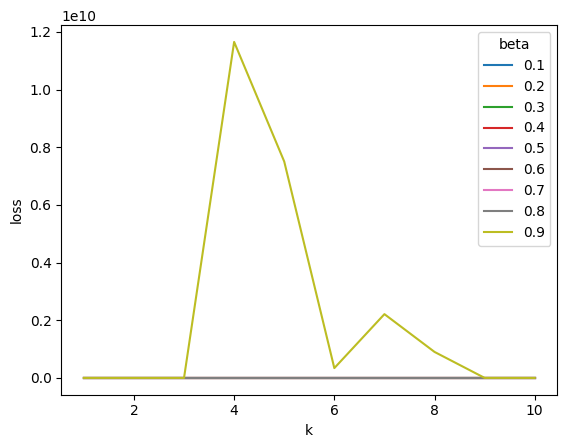

In [10]:
sns.lineplot(data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10")

In [11]:
k_opt, beta_opt, _ = select_cs_results.sort_values(by="loss").iloc[0]
k_opt = int(k_opt)
beta_opt = float(beta_opt)

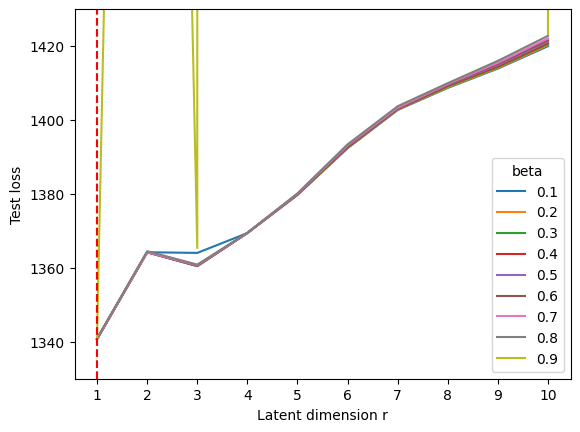

In [16]:
fig, ax = plt.subplots()
latent_dim_search_counts = sns.lineplot(
    data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10"
)
plt.ylabel("Test loss")
plt.xlabel("Latent dimension r")
plt.ylim([1330, 1430])
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.axvline(x=k_opt, color="red", linestyle="dashed")

plt.savefig(f"{figure_path}/select_r_beta_cs.svg")
plt.show()

In [17]:
print(f"Optimal latent dim: {k_opt}")
print(f"Optimal beta: {beta_opt}")

Optimal latent dim: 1
Optimal beta: 0.6


In [19]:
data.uns["BacSC_params_NMD"] = {"k_opt": k_opt, "beta_opt": beta_opt}

## Fit NMD with found parameters

In [20]:
n, p = data.X.shape

In [21]:
X_nmd = ut.convert_to_dense(data, layer=layer)
X_nmd = X_nmd.astype(float)
W0, H0 = cs.nuclear_norm_init(X_nmd, n, p, k_opt)
Theta0 = W0 @ H0

In [22]:
init_strat = InitializationStrategy.KNOWN_MATRIX
kernel_strat = KernelStrategy.MOMENTUM_3_BLOCK_MODEL_FREE

In [23]:
kernel_params = kernelInputTypes.Momentum3BlockAdditionalParameters(
    momentum_beta=beta_opt,
    candidate_factor_W0=W0,
    candidate_factor_H0=H0,
)
nmd_result = nmd.decompose(
    X_nmd,
    k_opt,
    kernel_strategy=kernel_strat,
    initialization=init_strat,
    kernel_params=kernel_params,
    manual_max_iterations=200,
    verbose=True,
    tolerance=None,
)

INFO:fi_nomad.entry:	Initiating run, target_rank: 1, tolerance: None
INFO:fi_nomad.entry:200 total, final loss Not Tracked
INFO:fi_nomad.entry:	Initialization took 3.401600042707287e-05 loop took 32.82794483100042 overall (0.1641397241550021/ea)


In [24]:
data.obsm["X_nmd"] = nmd_result.factors[0]
data.varm["nmd_components"] = nmd_result.factors[1].T
data.layers["Theta_nmd"] = nmd_result.factors[0] @ nmd_result.factors[1]

## Investigate NMD embeddings, "components" and reconstruction

#### Reconstruction

Plot reconstruction of the data before and after fitting NMD.

In [25]:
df_reconstruction_nuclearinit_nmd = pd.DataFrame.from_dict(
    {
        layer: ut.convert_to_dense_counts(data, layer=layer).flatten(),
        "nuclear_init": np.maximum(0, W0 @ H0).flatten(),
        "3B-NMD": np.maximum(
            0, data.obsm["X_nmd"] @ data.varm["nmd_components"].T
        ).flatten(),
    }
)

max_val = max(
    np.max(df_reconstruction_nuclearinit_nmd[layer]),
    np.max(df_reconstruction_nuclearinit_nmd["nuclear_init"]),
    np.max(df_reconstruction_nuclearinit_nmd["3B-NMD"]),
)

corr_orig_nuclear = np.corrcoef(
    df_reconstruction_nuclearinit_nmd[layer],
    df_reconstruction_nuclearinit_nmd["nuclear_init"],
)[0][1]
corr_orig_3bnmd = np.corrcoef(
    df_reconstruction_nuclearinit_nmd[layer],
    df_reconstruction_nuclearinit_nmd["3B-NMD"],
)[0][1]

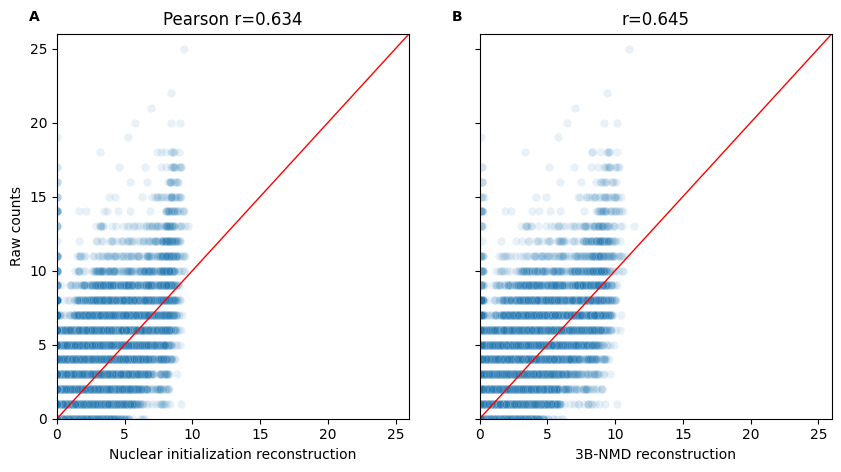

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

sns.scatterplot(
    data=df_reconstruction_nuclearinit_nmd, y=layer, x="nuclear_init", alpha=0.1, ax=ax1
)
ax1.set_title(f"Pearson r={corr_orig_nuclear:.3f}")
ax1.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
ax1.set_ylim((0, max_val + 1))
ax1.set_xlim((0, max_val + 1))
ax1.set_ylabel("Raw counts")
ax1.set_xlabel("Nuclear initialization reconstruction")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.scatterplot(
    data=df_reconstruction_nuclearinit_nmd, y=layer, x="3B-NMD", alpha=0.1, ax=ax2
)
ax2.set_title(f"r={corr_orig_3bnmd:.3f}")
ax2.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
# ax2.set_ylim((0, max_val))
# ax2.set_xlim((0, max_val))
ax2.set_ylabel(None)
ax2.set_xlabel("3B-NMD reconstruction")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

# plt.savefig(f"{figure_path}/reconstruction_nuclear_init_vs_3bnmd.svg", format="svg")
plt.savefig(
    f"{figure_path}/reconstruction_nuclear_init_vs_3bnmd.png", format="png", dpi=300
)
plt.show()

#### NMD embeddings: before and after fitting

Comparison of NMD embeddings before (results of nuclear initialization) and after fitting NMD

In [27]:
W0_length = len(W0[:, 0:1].flatten())
dict_histogram_W0nuclear_vs_W_nmd = {
    "dim_1": np.concatenate((W0[:, 0:1], data.obsm["X_nmd"][:, 0:1])).flatten(),
    "W0_W_nmd": ["W0 (nuclear init.)"] * W0_length + ["W (3B-NMD)"] * W0_length,
}
df_histogram_W0nuclear_vs_W_nmd_r1 = pd.DataFrame.from_dict(
    dict_histogram_W0nuclear_vs_W_nmd
)

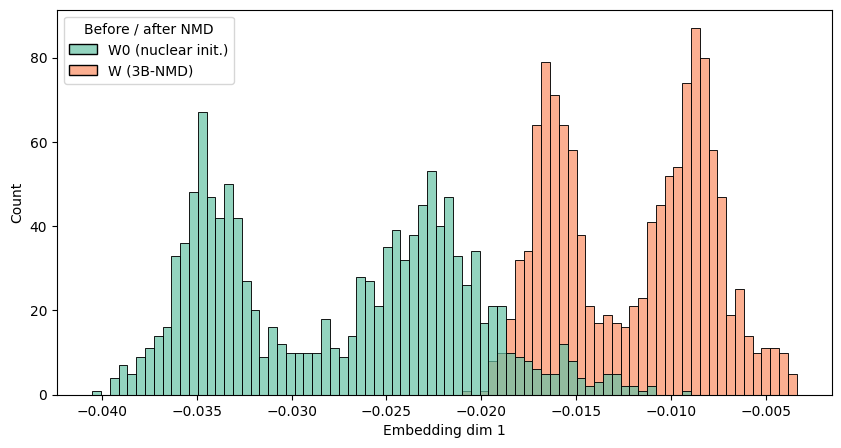

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
histogram_W0_dim1_nuclear_vs_W_nmd_r1 = sns.histplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1,
    x="dim_1",
    hue="W0_W_nmd",
    bins=80,
    alpha=0.7,
    palette="Set2",
)
histogram_W0_dim1_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding dim 1")

plt.savefig(f"{figure_path}/histogram_W0_dim1_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

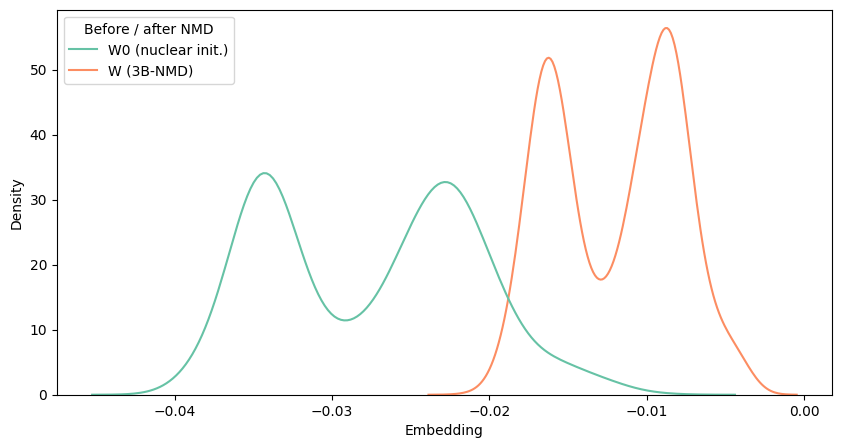

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
kdeplot_W0_dim1_nuclear_vs_W_nmd_r1 = sns.kdeplot(
    data=df_histogram_W0nuclear_vs_W_nmd_r1, x="dim_1", hue="W0_W_nmd", palette="Set2"
)
kdeplot_W0_dim1_nuclear_vs_W_nmd_r1.legend_.set_title("Before / after NMD")
ax.set_xlabel("Embedding")

plt.savefig(f"{figure_path}/kdeplot_W0_dim1_nuclear_vs_W_nmd.svg", format="svg")
plt.show()

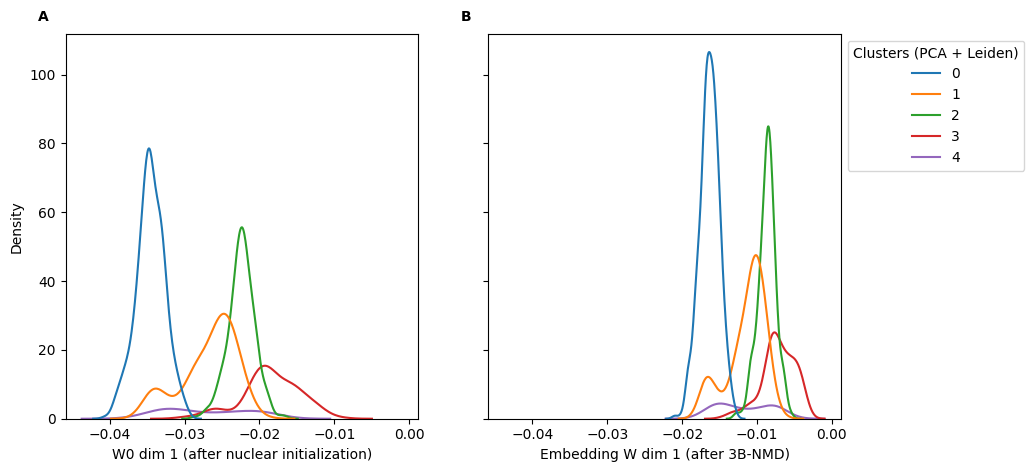

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
sns.kdeplot(x=W0.flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax1, legend=False)
ax1.set_xlabel("W0 dim 1 (after nuclear initialization)")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax1.text(
    0.0,
    1.0,
    "A",
    transform=ax1.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)

sns.kdeplot(
    x=data.obsm["X_nmd"].flatten(), hue=data.obs["leiden_opt_PCA"], ax=ax2
).axes.legend_.set_title("Clusters (PCA + Leiden)")
ax2.set_xlabel("Embedding W dim 1 (after 3B-NMD)")
ax2.text(
    0.0,
    1.0,
    "B",
    transform=ax2.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))


plt.savefig(
    f"{figure_path}/kde_W0_dim1_nuclear_vs_W_nmd_by_pca_cluster.svg", format="svg"
)
plt.show()

#### NMD embeddings vs. sequencing depth

Embeddings dimension vs. sequencing depth.

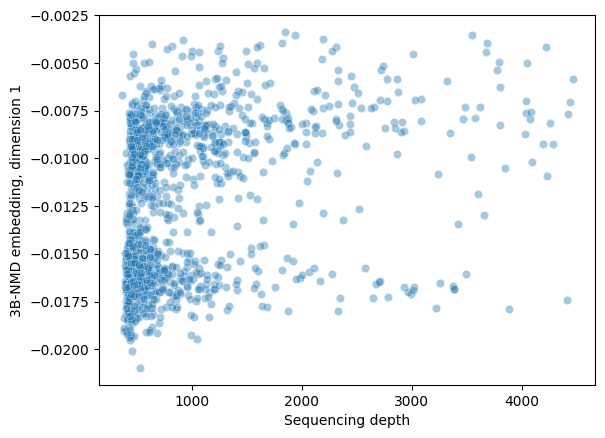

In [32]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.obsm["X_nmd"][:, 0:1].flatten(), x=data.obs["total_counts"], alpha=0.4
)
plt.ylabel("3B-NMD embedding, dimension 1")
plt.xlabel("Sequencing depth")


plt.savefig(f"{figure_path}/scatter_seqdepth_nmd_dim1.svg", format="svg")
plt.show()

In [33]:
corr_dim2_seqdepth = np.corrcoef(
    data.obsm["X_nmd"].flatten(), data.obs["total_counts"]
)[0][1]

print(
    f"Correlation between embedding dim 1 and sequencing depth: {corr_dim2_seqdepth:.3f}"
)

Correlation between embedding dim 1 and sequencing depth: 0.287


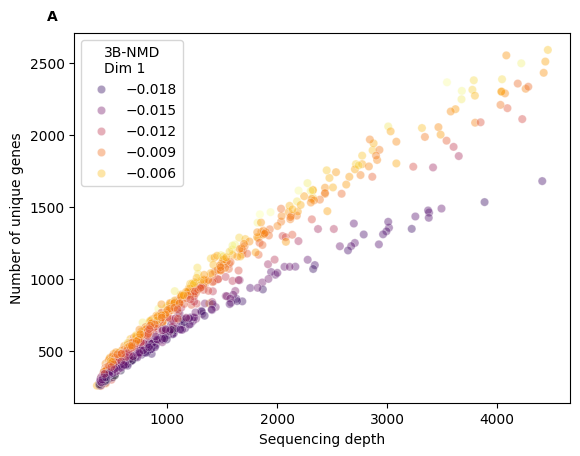

In [34]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=data.obs["total_counts"],
    y=data.obs["n_genes_by_counts"],
    hue=data.obsm["X_nmd"][:, :1].flatten(),
    alpha=0.4,
    palette="inferno",
    ax=ax,
)
ax.set_ylabel("Number of unique genes")
ax.set_xlabel("Sequencing depth")
ax.legend_.set_title("3B-NMD\nDim 1")
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
ax.text(
    0.0,
    1.0,
    "A",
    transform=ax.transAxes + trans,
    fontsize="medium",
    va="bottom",
    fontweight="bold",
)
plt.savefig(f"{figure_path}/sequencingdepth_uniquegenes_hueNMD.svg", format="svg")
plt.show()

#### NMD "components" vs. mean counts

NMD "components" are `p x k`, where `p` is the number of columns in the original data and `k` is the number of NMD latent dimensions.

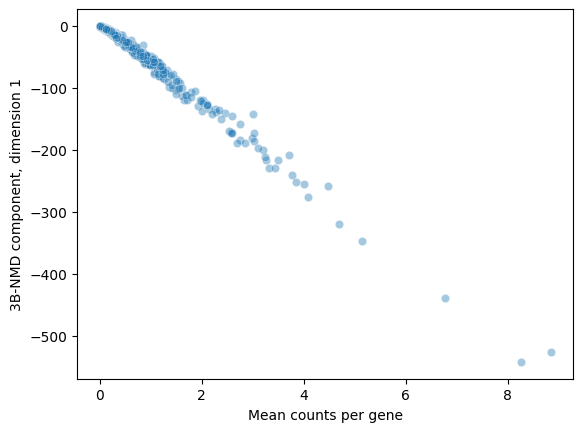

In [35]:
scatter_seqdepth_nmd_dim1 = sns.scatterplot(
    y=data.varm["nmd_components"].flatten(),
    x=data.var["mean_counts"],
    alpha=0.4,
)
plt.ylabel("3B-NMD component, dimension 1")
plt.xlabel("Mean counts per gene")


plt.savefig(f"{figure_path}/scatter_mean_counts_nmd_comp1.svg", format="svg")
plt.show()

In [36]:
corr_comp_meancountspergene = np.corrcoef(
    data.varm["nmd_components"].flatten(), data.var["mean_counts"]
)[0][1]

print(
    f"Correlation between embedding component 1 and mean counts per gene: {corr_comp_meancountspergene:.3f}"
)

Correlation between embedding component 1 and mean counts per gene: -0.994


#### NMD embeddings vs. PCs

Colored by clustering found using PCA + Leiden

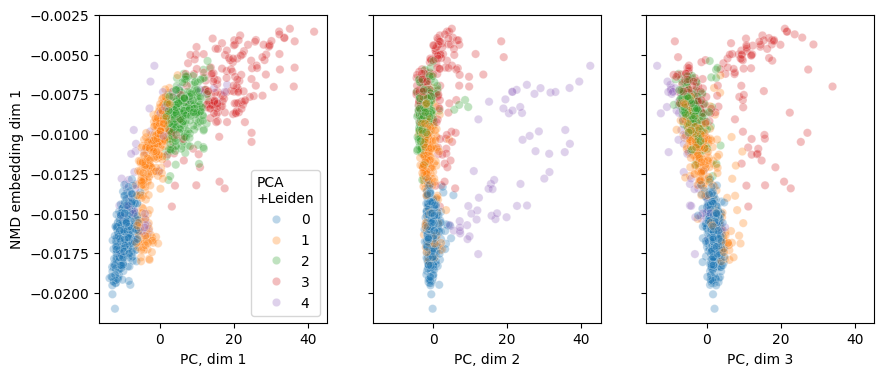

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(
    y=data.obsm["X_nmd"].flatten(),
    x=data.obsm["X_pca"][:, 0:1].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax1,
)
ax1.set_xlabel("PC, dim 1")
ax1.set_ylabel("NMD embedding dim 1")
ax1.legend_.set_title("PCA\n+Leiden")

sns.scatterplot(
    y=data.obsm["X_nmd"].flatten(),
    x=data.obsm["X_pca"][:, 1:2].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax2,
)
ax2.set_xlabel("PC, dim 2")
ax2.legend_.set_visible(None)

sns.scatterplot(
    y=data.obsm["X_nmd"].flatten(),
    x=data.obsm["X_pca"][:, 2:3].flatten(),
    alpha=0.3,
    hue=data.obs["leiden_opt_PCA"],
    ax=ax3,
)
ax3.set_xlabel("PC, dim 3")
ax3.legend_.set_visible(None)

plt.show()

In [38]:
data.write(data_path + "/nmd_normalized_counts.h5ad")